### Resources:
* [D-separation steps](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)
* [bnlearn datasets](https://www.bnlearn.com/bnrepository/)
* [Daggity paper](https://academic.oup.com/ije/article/45/6/1887/2907796)
* [Milestone](https://gitlab.pnnl.gov/y0-scuc/y0-archive/-/milestones/4)
* [pgmpy](https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb)  -- get_independencies

### TODO:
* Break into module, write proper unit tests
* What about conditional independencies?  Currently only covers independencies.  
   * Can I just enumerate tripples and check 'A,B given=["C"]'?  
   * Would then check combinations-pairs + combinations-givens 
   * Up to how many givens do you check?

In [1]:
from y0.algorithm import falsification
from y0.graph import ADMG
import networkx as nx
import pandas as pd

import seaborn as sns
from itertools import chain
%matplotlib inline

%load_ext autoreload
%autoreload 2

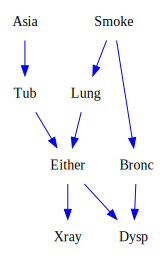

In [2]:
edges = [("Asia", "Tub"), 
         ("Smoke", "Lung"), ("Smoke", "Bronc"),
         ("Tub", "Either"),
         ("Lung", "Either"),
         ("Either", "Xray"), ("Either", "Dysp"),
         ("Bronc", "Dysp")]

#asia_G = nx.DiGraph(edges)
asia_G = ADMG()
for v in chain(*edges): asia_G.add_vertex(v)
for e in edges: asia_G.add_diedge(*e)
    
asia_df = pd.read_csv("asia.csv", index_col=0)\
            .replace({"yes":1, "no":-1})

asia_G.draw()


In [3]:
issues = falsification.falsifications(asia_G, asia_df, max_given=2)
issues

30          (Asia, Lung, (Xray, Tub))
125      (Lung, Bronc, (Asia, Smoke))
12        (Asia, Either, (Xray, Tub))
109    (Either, Bronc, (Lung, Smoke))
127    (Lung, Bronc, (Either, Smoke))
139            (Bronc, Tub, (Smoke,))
143       (Bronc, Tub, (Xray, Smoke))
145     (Bronc, Tub, (Either, Smoke))
100       (Xray, Tub, (Either, Lung))
dtype: object+evidence

In [4]:
issues.evidence

,A,B,Given,chi^2,p-value,dof,flagged
30,Asia,Lung,"(Xray, Tub)",8.428397,0.037940,3,True
125,Lung,Bronc,"(Asia, Smoke)",8.043061,0.045130,3,True
12,Asia,Either,"(Xray, Tub)",7.857395,0.019669,2,True
109,Either,Bronc,"(Lung, Smoke)",6.276336,0.043362,2,True
127,Lung,Bronc,"(Either, Smoke)",7.502014,0.023494,2,True
...,...,...,...,...,...,...,...
154,Smoke,Tub,"(Either, Lung)",0.020738,0.885494,1,False
14,Asia,Either,"(Lung, Tub)",0.000000,NaN,0,False
73,Xray,Lung,"(Either, Tub)",0.000000,NaN,0,False
110,Either,Bronc,"(Lung, Tub)",0.000000,NaN,0,False


In [7]:
# Should be issues (Lung, Either) AT LEAST.
#.  Seeing issues (Lung, Xray) as well.  Is that all? 
# TODO: Check d-separations by hand...
import copy
asia_G2 = copy.deepcopy(asia_G)
asia_G2.delete_diedge("Lung", "Either")
issues = falsification.falsifications(asia_G2, asia_df, max_given=0)
issues

3       (Xray, Lung, ())
4      (Xray, Bronc, ())
5      (Xray, Smoke, ())
6     (Either, Lung, ())
7    (Either, Bronc, ())
8    (Either, Smoke, ())
dtype: object+evidence